In [1]:
!pip install -r requirements.txt
# !pip install tensorflow yfinance pandas sklearn

In [2]:
import pandas as pd
import tensorflow as tf
import yfinance as yf

In [3]:
from datetime import datetime, timedelta
end_date = datetime.today().strftime('%Y-%m-%d')
start_date_dt = datetime.now() - timedelta(days=10*365)
start_date = start_date_dt.strftime('%Y-%m-%d')
nflx = yf.download("NFLX", start = start_date, end = end_date)

[*********************100%***********************]  1 of 1 completed


In [4]:
df = pd.DataFrame(nflx)
df1 = df.reset_index()['Close']

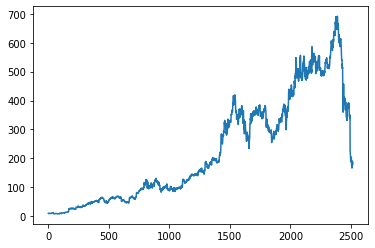

In [5]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [6]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [7]:
# Split data
train_size = int(len(df1)*.95) # 95%
test_size = len(df1) - train_size
train, test = df1[0:train_size,:], df1[train_size:len(df1), :1]

In [8]:
def create_dataset(data, time_step=1):
    dataX, dataY = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(data[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [9]:
time_step = 100
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

In [10]:
# Reshape to be inputted into LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [11]:
# Create Stacked LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(Dropout(.5))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-traina

In [13]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=250, verbose=1)

Epoch 1/100
10/10 [==============================] - 11s 535ms/step - loss: 0.0593 - val_loss: 0.0152
Epoch 2/100
10/10 [==============================] - 4s 413ms/step - loss: 0.0111 - val_loss: 0.0746
Epoch 3/100
10/10 [==============================] - 4s 437ms/step - loss: 0.0036 - val_loss: 0.0366
Epoch 4/100
10/10 [==============================] - 4s 439ms/step - loss: 0.0024 - val_loss: 0.0205
Epoch 5/100
10/10 [==============================] - 4s 441ms/step - loss: 0.0015 - val_loss: 0.0298
Epoch 6/100
10/10 [==============================] - 5s 453ms/step - loss: 0.0013 - val_loss: 0.0387
Epoch 7/100
10/10 [==============================] - 5s 452ms/step - loss: 0.0011 - val_loss: 0.0373
Epoch 8/100
10/10 [==============================] - 5s 446ms/step - loss: 0.0011 - val_loss: 0.0368
Epoch 9/100
10/10 [==============================] - 5s 456ms/step - loss: 0.0010 - val_loss: 0.0333
Epoch 10/100
10/10 [==============================] - 5s 454ms/step - loss: 0.0011 - val_l

In [14]:
prediction = model.predict(X_train)
test_prediction = model.predict(X_test)

In [15]:
prediction = scaler.inverse_transform(prediction)
test_prediction = scaler.inverse_transform(test_prediction)

In [16]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, prediction))

279.456584502621

In [17]:
math.sqrt(mean_squared_error(y_test, test_prediction))

281.7972971380122

In [18]:
x_input = test[len(test)-100:].reshape(1, -1)

In [19]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [20]:
# Prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while i<30:

    if len(temp_input)>100:
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1

1 day input [0.88136036 0.8836265  0.86951836 0.86210612 0.85301265 0.81846608
 0.79766205 0.77978208 0.77801305 0.77946048 0.77416804 0.74782323
 0.75731146 0.73554257 0.74294018 0.73181454 0.56990035 0.55476886
 0.52446206 0.51463756 0.554111   0.55068993 0.61323344 0.65707818
 0.61665446 0.58174239 0.58842365 0.57662547 0.57871609 0.59240023
 0.58272189 0.5608507  0.56854072 0.58446165 0.57074828 0.55406714
 0.56082148 0.54048534 0.52598249 0.55897937 0.56010508 0.56554364
 0.55343845 0.54435958 0.52687432 0.51760538 0.50083647 0.48840965
 0.51330715 0.51035393 0.4863044  0.47269338 0.49131898 0.51146505
 0.53174269 0.54519292 0.53640641 0.54858472 0.5362602  0.53804382
 0.53532456 0.54213738 0.56159632 0.54646483 0.53640641 0.534769
 0.56112848 0.54453501 0.52728367 0.51821938 0.50905279 0.49753239
 0.49183068 0.50108499 0.4874886  0.4827079  0.49842417 0.31944871
 0.30779674 0.3038494  0.29564769 0.2788203  0.26440518 0.28045773
 0.267066   0.28037002 0.28096941 0.287022   0.26408

In [21]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [22]:
print(scaler.inverse_transform(lst_output[0:]))

[[189.80529008]
 [189.41679434]
 [189.3496872 ]
 [189.53704496]
 [189.90077303]
 [190.36475411]
 [190.8647961 ]
 [191.35270908]
 [191.79746718]
 [192.18270133]
 [192.50319298]
 [192.7611641 ]
 [192.96319901]
 [193.11757398]
 [193.23313607]
 [193.31787616]
 [193.37884745]
 [193.42190039]
 [193.45186622]
 [193.47261806]
 [193.48717289]
 [193.49807883]
 [193.50731319]
 [193.51644563]
 [193.52663809]
 [193.53890981]
 [193.55385196]
 [193.57199453]
 [193.593521  ]
 [193.61863522]]


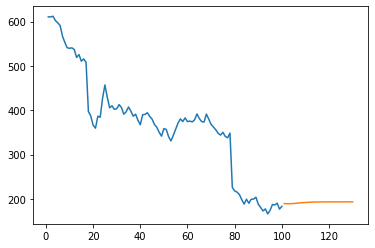

In [23]:
plt.plot(day_new,scaler.inverse_transform(df1[len(df1)-100:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

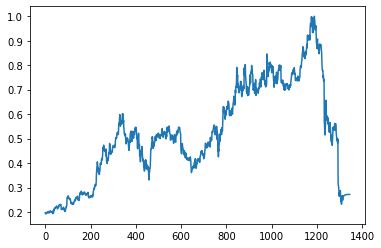

In [24]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [25]:
df3=scaler.inverse_transform(df3).tolist()

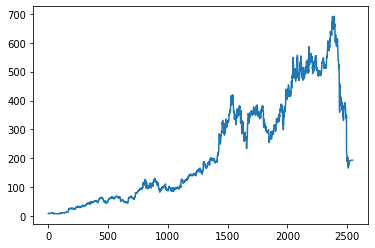

In [26]:
plt.plot(df3)

In [27]:
import time
from datetime import datetime

SECONDS_IN_DAY = 86400

now = int( time.time() )

data_set = {"c": [], "t": []}
inversed_output = scaler.inverse_transform(lst_output)
inversed_output.tolist()
for i in range(len(inversed_output)):
    now = SECONDS_IN_DAY + now
    data_set["c"].insert(i, round(float(inversed_output[i]), 2))
    data_set["t"].insert(i, int(now))

In [28]:
import json
with open('../src/stock_json/nflx.json', 'w', encoding='utf-8') as f:
    json.dump(data_set, f, ensure_ascii=False, indent=4)